In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt

import histlib.matchup as match
import histlib.diagnosis as diag
from histlib.cstes import labels, zarr_dir, matchup_dir, var
from histlib.matchup import _data_var, _stress_var, _aviso_var

from xhistogram.xarray import histogram


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm


/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [5]:
l = labels[0]

In [7]:
os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{int(DL//1000)}_{DT}_{dl}_{l}.zarr')

'/home/datawork-lops-osi/aponte/margot/historical_coloc_ok/mslonlat/mslonlat_100_10800_5_gps_Jason-3_2020.zarr'

In [3]:
if True:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster(cores=56, processes=28, walltime='04:00:00')
    #cluster = PBSCluster(cores=7, processes=7, walltime='04:00:00')
    cluster = PBSCluster(cores=28, processes=28, walltime='08:00:00')
    w = cluster.scale(jobs=1)
else:
    from dask.distributed import Client, LocalCluster
    cluster = LocalCluster()

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.1.39:8787/status,
Dashboard: http://10.148.1.39:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.1.39:50822,Workers: 0
Dashboard: http://10.148.1.39:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## IMPORT DATA, build dataset
We choose to get only erastar wind term, and we reject PEACHY data, and we select only deltaT<1H

In [3]:
DL =100*1e3 #meters
DT = 3*3600 #seconds
dl = 5

In [8]:
DT

10800

In [9]:
def bin_lonlat_ms(ds,l, dl):
    dsm = match.add_except_sum(ds)   
    dsm = dsm.reset_coords(['lon', 'lat', 'time']).drop(['id_comb', 'time'])
    dfm = dsm.to_dask_dataframe().set_index('obs')
    dfm["latbin"] = (dfm.lat // dl) * dl
    dfm["lonbin"] = (dfm.lon // dl) * dl
    #ms
    d2 = dfm.drop(['lon', 'lat', 'lonbin', 'latbin'], axis=1)**2
    dd = dfm[['lonbin', 'latbin']].merge(d2)
    dd = dd.groupby(["latbin", "lonbin"]).mean()
    #count
    dnb = dfm.reset_index()[['obs', 'latbin', 'lonbin']].groupby(["latbin", "lonbin"]).count().obs.compute().to_xarray()
    dsms = dd.compute().to_xarray()
    #attrs
    for v in list(dsms.variables) :
        if v in ds :
            dsms[v].attrs = ds[v].attrs
    #merge
    dso = xr.merge([dsms, dnb.rename('nb_coloc_bin')])
    dso['drifter_sat_year']=l
    dso = dso.expand_dims('drifter_sat_year')
    dso = dso.set_coords('drifter_sat_year')
    # center lon, lat bins + reindex to have same for all
    lon_bins, lat_bins = np.arange(-180, 180, dl), np.arange(-90, 90, dl)
    dso = dso.reindex({'lonbin':lon_bins, 'latbin':lat_bins})
    dso['lonbin'] = dso['lonbin']+dl/2
    dso['latbin'] = dso['latbin']+dl/2

    return dso

# Test 1 label

In [5]:
l=labels[0]
dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[var+['drogue_status', 'alti___distance', 'alti___time_difference']].dropna('obs').chunk({'obs':500})
dsm = dsm.where(dsm.alti___distance<=DL, drop=True)
dsm = dsm.where(dsm.alti___time_difference<=DT, drop=True).drop(['alti___distance', 'alti___time_difference'])
#dsmd = dsm.where(dsm.drogue_status, drop=True).drop('drogue_status')
#dsmnd = dsm.where(np.logical_not(dsm.drogue_status), drop=True).drop('drogue_status')
dsm = dsm.drop('drogue_status')
dsms= bin_lonlat_ms(dsm,l, dl)
dsms

<xarray.Dataset>
Dimensions:                                                                (
                                                                            lonbin: 72,
                                                                            latbin: 36,
                                                                            drifter_sat_year: 1)
Coordinates:
  * lonbin                                                                 (lonbin) float64 ...
  * latbin                                                                 (latbin) float64 ...
  * drifter_sat_year                                                       (drifter_sat_year) <U16 ...
Data variables: (12/435)
    e5_cstrio_z0_alti_wd_x                                                 (drifter_sat_year, latbin, lonbin) float64 ...
    e5_cstrio_z0_drifter_wd_x                                              (drifter_sat_year, latbin, lonbin) float64 ...
    e5_cstrio_z15_alti_wd_x                                                (drifter_sat_year, latbin, lonbin) float64 ...
    e5_cstrio_z15_drifter_wd_x                                             (drifter_sat_year, latbin, lonbin) float64 ...
    es_cstrio_z0_alti_wd_x                                                 (drifter_sat_year, latbin, lonbin) float64 ...
    es_cstrio_z0_drifter_wd_x                                              (drifter_sat_year, latbin, lonbin) float64 ...
    ...                                                                     ...
    sum_aviso__0__adt__es_cstrio_z15__drifter_y                            (drifter_sat_year, latbin, lonbin) float64 ...
    sum_aviso__0__sla__e5_cstrio_z0__drifter_y                             (drifter_sat_year, latbin, lonbin) float64 ...
    sum_aviso__0__sla__e5_cstrio_z15__drifter_y                            (drifter_sat_year, latbin, lonbin) float64 ...
    sum_aviso__0__sla__es_cstrio_z0__drifter_y                             (drifter_sat_year, latbin, lonbin) float64 ...
    sum_aviso__0__sla__es_cstrio_z15__drifter_y                            (drifter_sat_year, latbin, lonbin) float64 ...
    nb_coloc_bin                                                           (drifter_sat_year, latbin, lonbin) float64 ...

In [ ]:
# VERSION SI CALCUL ASSEZ COURT-> PAS LE CAS
for l in labels : 
    dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[var+['drogue_status', 'alti___distance', 'alti___time_difference']].dropna('obs').chunk({'obs':500})
    dsm = dsm.where(dsm.alti___distance<=DL, drop=True)
    dsm = dsm.where(dsm.alti___time_difference<=DT, drop=True).drop(['alti___distance', 'alti___time_difference'])
    dsmd = dsm.where(dsm.drogue_status, drop=True).drop('drogue_status')
    dsmnd = dsm.where(np.logical_not(dsm.drogue_status), drop=True).drop('drogue_status')
    dsm = dsm.drop('drogue_status')
    if l==labels[0] : 
        bin_lonlat_ms(dsm, l, dl).to_zarr(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}.zarr'),encoding={'drifter_sat_year':{'dtype':'U32'}}, mode='w')
        if dsmd.dims['obs']!=0 : 
            bin_lonlat_ms(dsmd,l, dl).to_zarr(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}_drogued.zarr'), encoding={'drifter_sat_year':{'dtype':'U32'}},mode='w')
        if dsmnd.dims['obs']!=0 : 
            bin_lonlat_ms(dsmnd,l, dl).to_zarr(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}_undrogued.zarr'),encoding={'drifter_sat_year':{'dtype':'U32'}}, mode='w')
    else : 
        bin_lonlat_ms(dsm,l, dl).to_zarr(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}.zarr'), append_dim='drifter_sat_year')
        if dsmd.dims['obs']!=0 : 
            bin_lonlat_ms(dsmd,l, dl).to_zarr(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}_drogued.zarr'), append_dim='drifter_sat_year')
        if dsmnd.dims['obs']!=0 : 
            bin_lonlat_ms(dsmnd,l, dl).to_zarr(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}_undrogued.zarr'),append_dim='drifter_sat_year')
    print(l)


gps_Jason-3_2020
argos_Jason-3_2020
gps_SARAL_2020
argos_SARAL_2020
gps_Cryosat-2_2020
argos_Cryosat-2_2020
gps_Sentinel-3_A_2020
argos_Sentinel-3_A_2020
gps_Sentinel-3_B_2020
argos_Sentinel-3_B_2020
gps_Jason-3_2019
argos_Jason-3_2019
gps_SARAL_2019
argos_SARAL_2019


____________

In [6]:
ds = xr.open_dataset(os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}_undrogued.zarr')).chunk({'drifter_sat_year':1})

In [7]:
undone_label = [l for l in labels if l not in ds.isel(drifter_sat_year=slice(0, -1)).drifter_sat_year]

In [ ]:
# VERSION CALCUL LONG -> UN FICHIER PAR L
for l in undone_label : 
    dsm = xr.open_dataset(os.path.join(matchup_dir, f'matchup_{l}.zarr'))[var+['drogue_status', 'alti___distance', 'alti___time_difference']].dropna('obs').chunk({'obs':500})
    dsm = dsm.where(dsm.alti___distance<=DL, drop=True)
    dsm = dsm.where(dsm.alti___time_difference<=DT, drop=True).drop(['alti___distance', 'alti___time_difference'])
    dsmd = dsm.where(dsm.drogue_status, drop=True).drop('drogue_status')
    dsmnd = dsm.where(np.logical_not(dsm.drogue_status), drop=True).drop('drogue_status')
    dsm = dsm.drop('drogue_status')
    zarr = os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{DL//1000}_{DT}_{dl}_{l}.zarr')
    if os.path.isdir(zarr) :
        bin_lonlat_ms(dsm,l, dl).to_zarr(zarr,encoding={'drifter_sat_year':{'dtype':'U32'}}, mode='w')
    if dsmd.dims['obs']!=0 : 
        zarrd = os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{DL//1000}_{DT}_{dl}_drogued_{l}.zarr')
        if os.path.isdir(zarrd) :
            bin_lonlat_ms(dsmd,l, dl).to_zarr(zarrd, encoding={'drifter_sat_year':{'dtype':'U32'}},mode='w')
    if dsmnd.dims['obs']!=0 :
        zarrud = os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{DL//1000}_{DT}_{dl}_undrogued_{l}.zarr')
        if os.path.isdir(zarrud) :
            bin_lonlat_ms(dsmnd,l, dl).to_zarr(zarrud,encoding={'drifter_sat_year':{'dtype':'U32'}}, mode='w')
    print(l)


____________
# CONCATENATE
BIG file : os.path.join(zarr_dir+'_ok',f'mslonlat_{DL//1000}_{DT}_{dl}_undrogued.zarr'
+ small in os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{DL//1000}_{DT}_{dl}_undrogued.zarr'

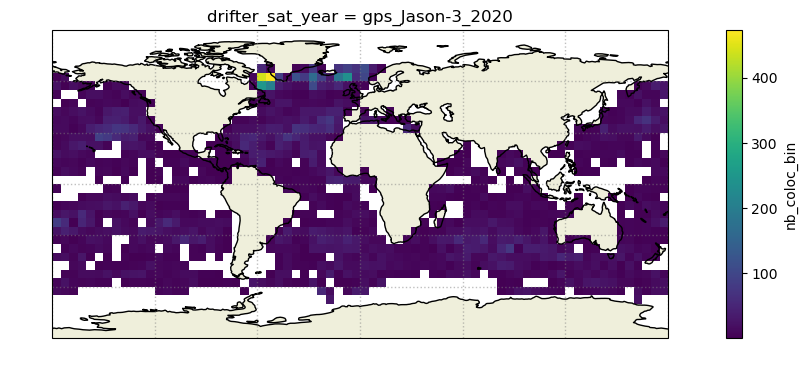

In [7]:
cmap='viridis'
# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(1,1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(15,4))
dsms.nb_coloc_bin.plot(x='lonbin', y='latbin', cmap=cmap, ax=axs)

# Draw the coastines for each subplot
axs.coastlines()
axs.add_feature(cfeature.LAND)
#gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
#          linewidth=1, color='gray', alpha=0.5, linestyle=':')
gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='gray', alpha=0.5, linestyle=':', xlabel_style = {'color': 'w'}, ylabel_style = {'color': 'w'})
gl.xlabels_top = False
gl.ylabels_right = False

In [1]:
cluster.close()

NameError: name 'cluster' is not defined